In [1]:
import pandas as pd
import numpy as np
import gc
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
import time

%matplotlib inline
import seaborn as sns

from sklearn import metrics

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
sns.set()

## !wget https://springernature.figshare.com/ndownloader/files/34135113

Given that the dataset contains recordings of vitals for 30 patients, to make the data easy to handle, we first created a list of dataframes where each dataframe contained per patient data

In [2]:
## a list to store the data for each patient 
dfs_list = []

We first start by loading the data...

In [3]:
f = open('./dataset_OSAS.pickle', 'rb')
data = pickle.load(f)
f.close()

Here we parse the entire data, remove duplicates and initialize the list of dataframes

In [4]:
## dropping duplicates from the data 
for i in range(1,31,1):
    df = data[data['patient'] == str(i)]
    df.drop_duplicates(subset=['timestamp_datetime'], inplace=True)
    dfs_list.append(df)

/usr/local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


As a first step towards EDA, we first wanted to see different statistics associated with each feature for our better understanding of the nature of the data we are handling

In [5]:
## using built-in function
data.describe()

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min),anomaly
count,957813.000000,828777.000000,828102.000000,942901.000000,957813.000000,961357
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,815917
mean,64.683292,95.479754,3.981212,15.894219,0.629161,NaN
std,14.302865,2.875233,2.416226,3.689678,2.308404,NaN
min,30.000000,60.000000,0.060000,5.000000,0.000000,NaN
25%,54.000000,94.000000,2.200000,13.000000,0.000000,NaN
50%,62.000000,96.000000,3.510000,15.000000,0.000000,NaN
75%,74.000000,97.000000,5.270000,18.000000,0.000000,NaN


As can be noticed from the chart above, there is significant variability in the counts of hypopanea events between subjects. Through the course of our project we would like to explore the reasons contributing to this difference. 

Text(0.5, 1.0, 'Number of Hypopnea Event for each Patient')

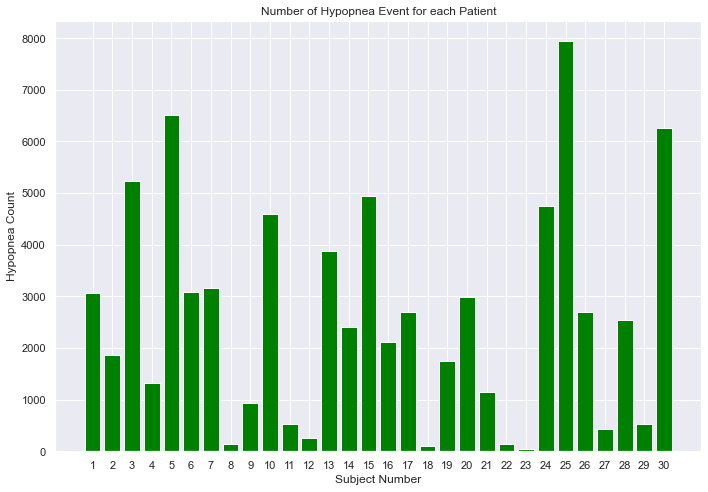

In [6]:
### plotting counts of hypopnea events for each patient 
hypopnea_list = []

for i in range(1,31,1):
    temp = data[data['patient'] == str(i)]
    temp = temp['event'].value_counts()
    temp = pd.DataFrame(temp)
    temp.reset_index(inplace = True)
    hypopnea = temp.loc[temp['index'] == 'HYPOPNEA']['event'].iloc[0]
    hypopnea_list.append(hypopnea)

plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True
x_vals = range(1,31,1)
plt.bar(x_vals, hypopnea_list, color = 'green')
plt.xticks(x_vals)
plt.xlabel("Subject Number")
plt.ylabel("Hypopnea Count")
plt.title("Number of Hypopnea Event for each Patient")

30


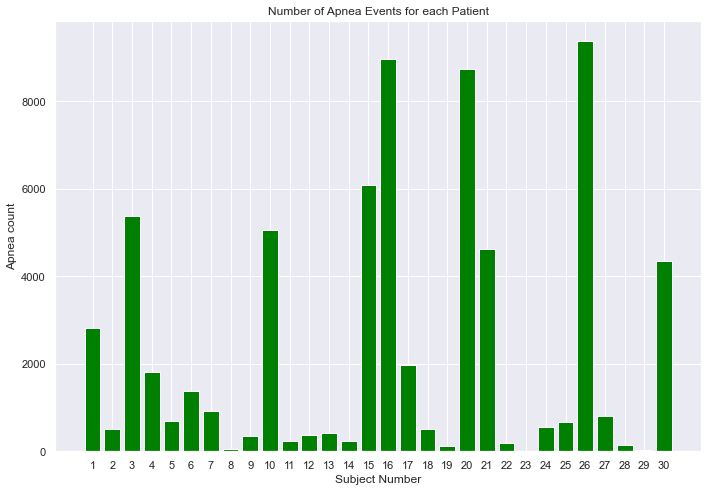

In [7]:
apnea_list = []
print(len(dfs_list))

for i in range(0,30,1):
    temp = dfs_list[i].query("event != 'HYPOPNEA'").query("event != 'NONE'")
    apnea_list.append(len(temp))

plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True
x_vals = range(1,31,1)
plt.bar(x_vals, apnea_list, color = 'green')
plt.xticks(x_vals)
plt.xlabel("Subject Number")
plt.ylabel("Apnea count")
plt.title("Number of Apnea Events for each Patient")

plt.show()

The variability in the information on apnea events is even more stark. This chart is useful for us as it drives the thought behind our main research question.

At this point,  it seemed like a good idea to find the relationship between different features. First, we found out the covariance in the dataset between all the numeric values.However, ad can be seen from the table, we were not able to find a statiscially significant result

In [8]:
data.cov()

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min),anomaly
HR(bpm),204.571948,-4.193349,-9.061032,17.302908,7.391100,-0.008272
SpO2(%),-4.193349,8.266963,-1.597757,-1.355408,-0.591348,-0.074999
PI(%),-9.061032,-1.597757,5.838146,-1.030264,-0.340358,-0.048826
RR(rpm),17.302908,-1.355408,-1.030264,13.613726,1.470620,0.009669
PVCs(/min),7.391100,-0.591348,-0.340358,1.470620,5.328729,0.063249
anomaly,-0.008272,-0.074999,-0.048826,0.009669,0.063249,0.128399


Next, we created a correlation matrix to see if any correlations exist

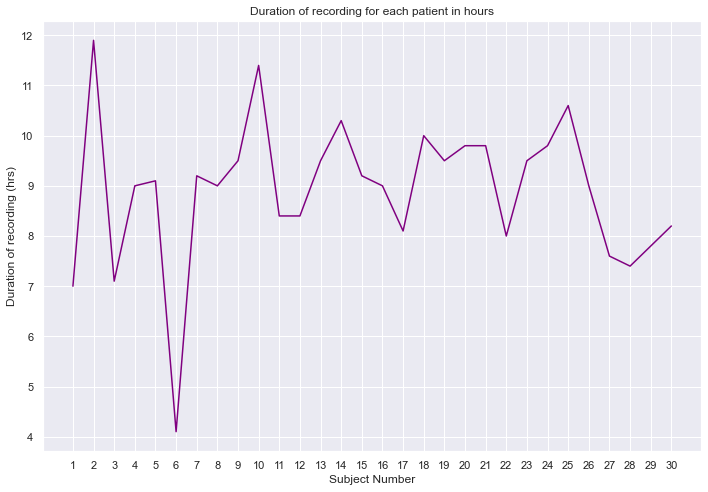

In [9]:
## finding the duration of time for each patient
count = 1
list_duration = []
for df in dfs_list:
    temp = list(df['timestamp_datetime'])
    t1 = temp[0]
    t2 = temp[-1]
    duration = round((t2 - t1).total_seconds() / 3600,1)
    list_duration.append(duration)

plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True
x_vals = range(1,31,1)
plt.plot(x_vals, list_duration, color = 'black', marker='o', linestyle='none')
plt.xticks(x_vals)
plt.xlabel("Subject Number")
plt.ylabel("Duration of recording (hrs)")
plt.title("Duration of recording for each patient in hours")

plt.show()

As can be seen, there is a significant difference in the duration of recording between the subjects, especially for subject 6 and 12. Later as we analyse the data, we will explore further how that factors into the detection of apnea events.

Next we attempt to get an understanding of data ranges.

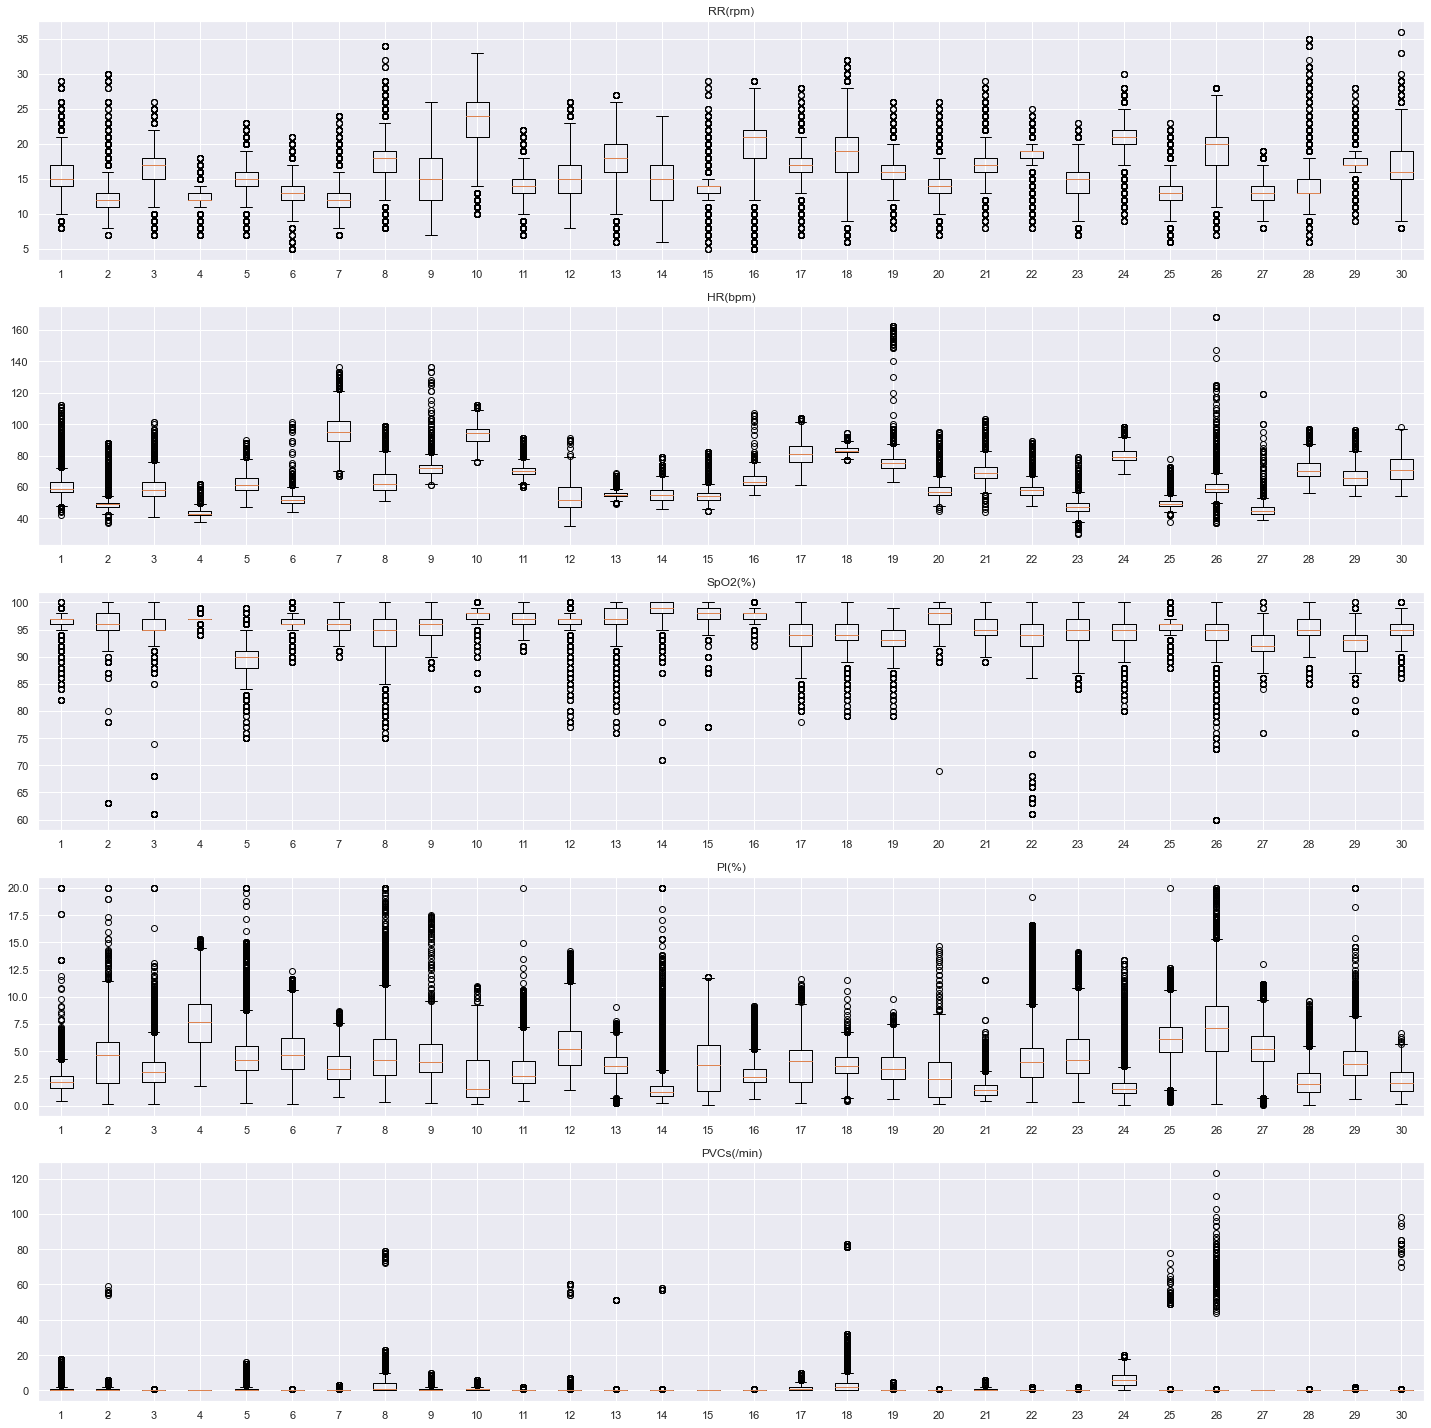

In [10]:
features = ['RR(rpm)', 'HR(bpm)', 'SpO2(%)', 'PI(%)', 'PVCs(/min)']

fig, ax = plt.subplots(nrows=len(features), ncols=1, figsize=(20,20))

## For each feature for the each patient, do a box plot
for index in range(len(features)):
    o = ax[index].set_title(features[index])
    
    patient_data = []
    for patient_id in np.unique(data['patient']):
        temp = data[data['patient'] == patient_id][features[index]]
        patient_data.append([x for x in list(temp.values) if not np.isnan(x)] )
    
    ax[index].boxplot(patient_data)

plt.show()

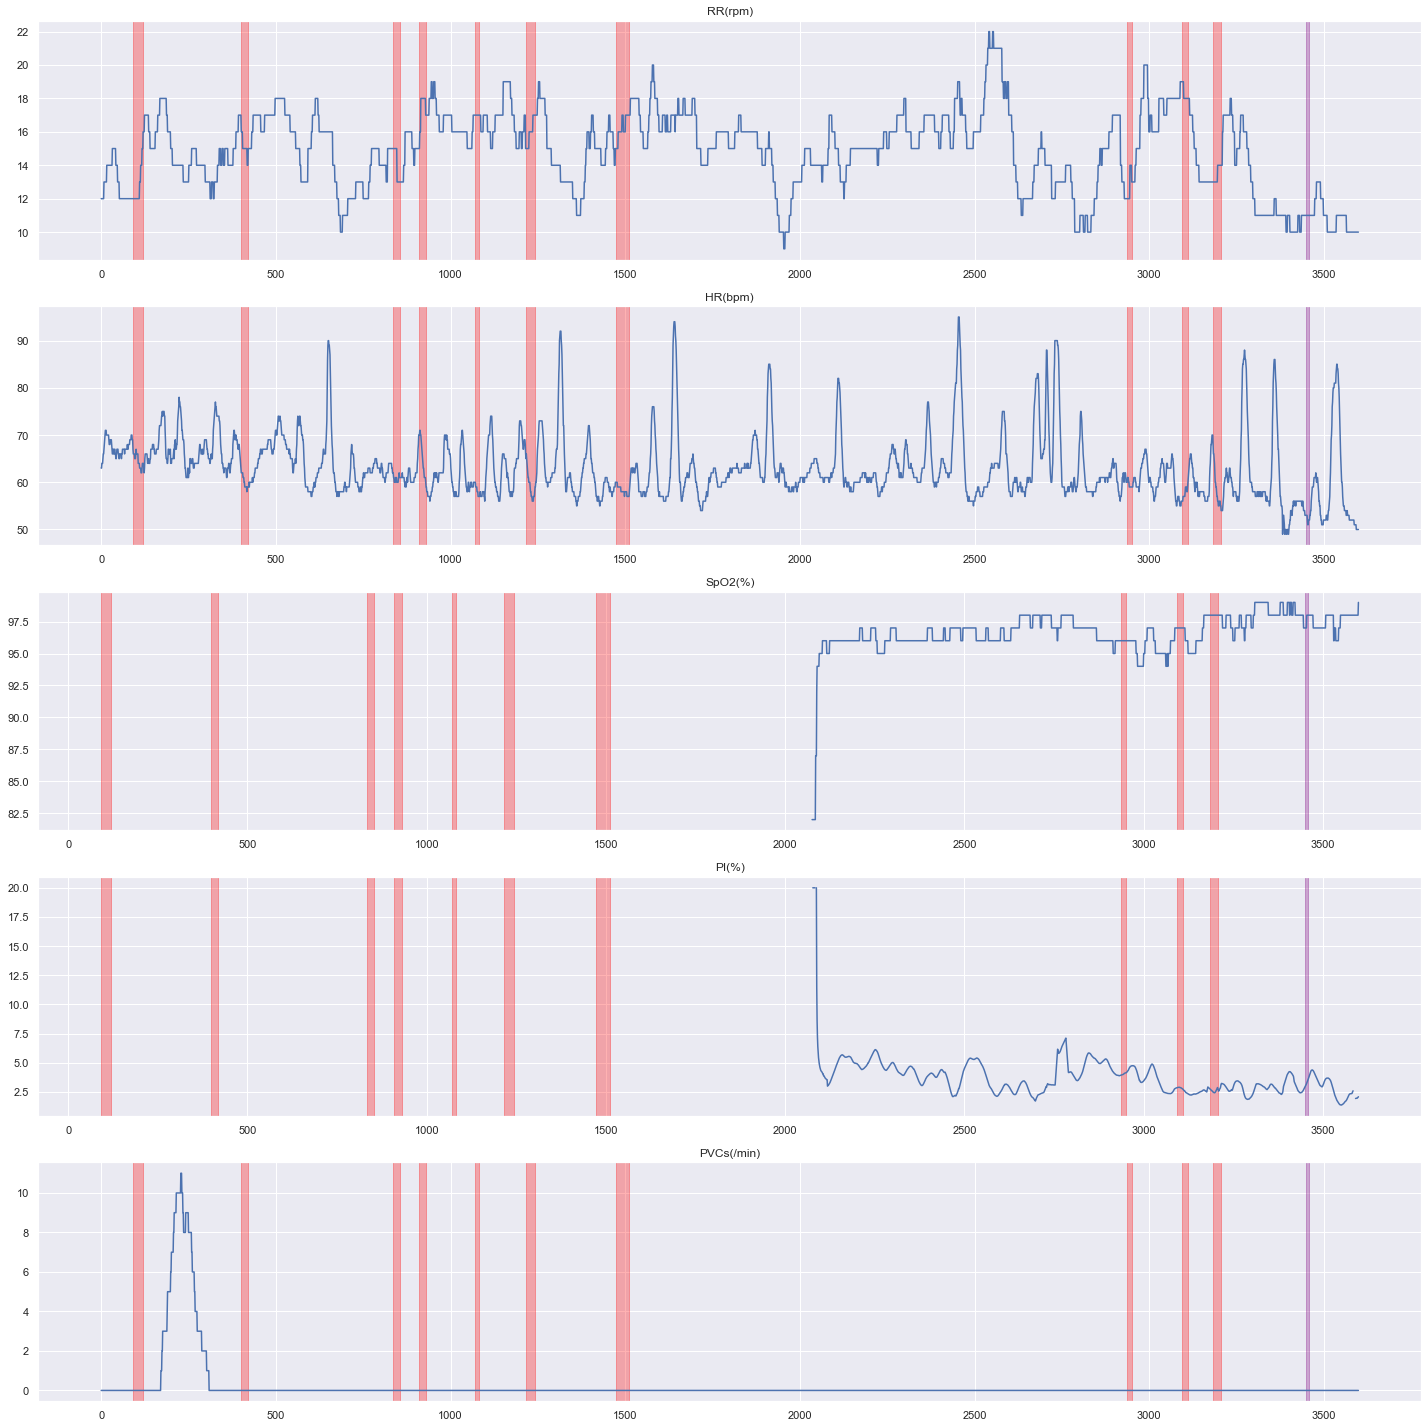

In [11]:
## Plot an hour of data for each of the features
## If you notice, the plots for SpO2 and PI% don't begin until around 2100 for patient 1
## The values for the first portions of the data are NaNs so the data is missing
## The fact that there is missing data can be seen more clearly in the bottom table where there is
##   approximately 8% data missing for both of these features.
## I believe that these two measurements are often collected via the same device so it is likely that
##   the NaNs are place values for the time prior to hooking up the device.
## In addition, the red markings on the time series plot indicates hypopnea events marked by a clinician
##   while the purple marking indicates an apnea event. Idealy we would be able to see some correlation.

## Takes a set of patient data (assumes only a single patient) and a start and end then returns
##    a list of start and ending tuples. You can also specify the types it expects a list of
##    the valid types such as ['APNEA-CENTRAL' 'APNEA-MIXED' 'APNEA-OBSTRUCTIVE' 'HYPOPNEA' 'NONE']
def get_list_of_events(df, start, end, event_type):
    
    ## Will be in the format of [ (start1, end1), (start2, end2)] ]
    event_list = []
    
    current_start = 0
    
    ## State identifier if we are inside of an event range or out of it
    in_event = 0
    
    for i in range(start, end + 1):
        ## We are in an event if it is both the correct type and we have encountered a 1
        if df['anomaly'][i] == 1 and in_event == 0 and df['event'][i] in event_type:
            in_event = 1
            current_start = i
        elif df['anomaly'][i] == 1 and in_event == 1 and df['event'][i] not in event_type:
            ## If we are in an event and the type switches we have to stop
            in_event = 0
            event_list.append( (current_start, i - 1) )
        elif df['anomaly'][i] == 0 and in_event == 1:
            in_event = 0
            event_list.append( (current_start, i - 1) )
    
    return event_list
        
fig, ax = plt.subplots(nrows=len(features), ncols=1, figsize=(20,20))

## For each feature for the first patient, graph a time series over the first hour of monitoring
for index in range(len(features)):
    ax[index].set_title(features[index])
    
    ## Only take the first hour of data
    plot_data = data[data['patient'] == '1'][features[index]].head(3600)
    
    ax[index].plot(list(range(0,3600)), plot_data, color='b')
    
    apnea_events = get_list_of_events(data[data['patient'] == '1'], 0, 3600, ['APNEA-CENTRAL','APNEA-MIXED','APNEA-OBSTRUCTIVE'])
    hypopnea_events = get_list_of_events(data[data['patient'] == '1'], 0, 3600, ['HYPOPNEA'])
    
    for start, end in apnea_events:
        ax[index].axvspan(start, end, color="purple", alpha=0.3)
        
    for start, end in hypopnea_events:
        ax[index].axvspan(start, end, color="red", alpha=0.3)
    
plt.show()

In [12]:
## Calculate missing data %

## Some of these patients have significant chunks of missing data primarily in regards to SpO2 and PI%
##  Given how much is missing we may not be able to depend too heavily on these features for training our model.

patient_missing = {}

for feat in features:

    patient_missing[feat] = []
    
    for patient_id in np.unique(data['patient']):
        temp = data[data['patient'] == patient_id][feat]
        vals = list(temp.values)
        missing = len([x for x in vals if np.isnan(x)] ) / len(vals)
        patient_missing[feat].append(missing)

df = pd.DataFrame(patient_missing, index = np.unique(data['patient']))
display(df)

,RR(rpm),HR(bpm),SpO2(%),PI(%),PVCs(/min)
1,0.000040,0.000040,0.083287,0.084598,0.000040
10,0.058771,0.058454,0.177870,0.178991,0.058454
11,0.000033,0.000033,0.220888,0.222500,0.000033
12,0.015027,0.000033,0.000066,0.000066,0.000033
13,0.001645,0.000059,0.019127,0.020302,0.000059
14,0.001219,0.000027,0.025975,0.026842,0.000027
15,0.006132,0.001933,0.190545,0.190606,0.001933
16,0.044314,0.000464,0.119314,0.120674,0.000464
17,0.002415,0.000034,0.657295,0.657640,0.000034
18,0.000028,0.000028,0.373101,0.373686,0.000028


In [13]:
# Chose three random patients to show 
pt_nums = ['9', '17', '21']
events = ['PSG_Flow', 'PSG_Abdomen', 'PSG_Position', 'PSG_Snore', 'PSG_Thorax']

In [1]:
# Objective of the plot: to map the hypopnea and apnea events in patient readouts of polysomnography time series
# data. We were hoping to visualize the any patterns that were present in the PSG data. From our plots, we cannot
# see a clear pattern between PSG time series data and hypopnea and apnea events but we are hopeful that we can 
# use the time series data to train a machine learning algorithm to predict the hypopnea and apnea events from 
# PSG data as well as the other data in the dataset. 

for pt_num in pt_nums:
    patient = data[data['patient'] == pt_num]
    time = patient['timestamp_datetime']
    event = patient['event']
    
    for e in events:

        psg = patient[e]

        # collecting the data in an easier form to plot
        huge_arr = []
        time_arr = []
        event_arr = []
        for i in event.index:
            event_arr = np.append(event_arr, event[i])
            huge_arr = np.append(huge_arr, psg[i])
            time_arr = np.append(time_arr, time[i])

        # setting up plots -- 4000 was a number of points I chose that I thought 
        # didn't look too crowded in the space allocated for the plot
        num_plots = int(len(time_arr)/4000)
        fig, axs = plt.subplots(num_plots)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        fig.tight_layout()
        start = 0
        end = 4000
        for i in range(num_plots):
            # find the hypopnea and apnea events
            hypopnea = (event_arr[start:end] == 'HYPOPNEA')
            apnea = (event_arr[start:end] == 'APNEA-OBSTRUCTIVE')
            # plot the time series
            axs[i].plot(time_arr[start:end], huge_arr[start:end])
            # plot the hypopnea and apnea events
            for j in range(len(hypopnea)):
                if hypopnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='red', alpha=0.1)
            for j in range(len(apnea)):
                if apnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='purple', alpha=0.1)
            start += 4000
            end += 4000

        axs[0].set_title(str(e) + " for Patient "+ str(pt_num)+", Red = Hypopnea, Purple = Apnea")
        axs[num_plots-1].set_xlabel("Time")

NameError: name 'pt_nums' is not defined

In [16]:
ecg_events = ['signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii']

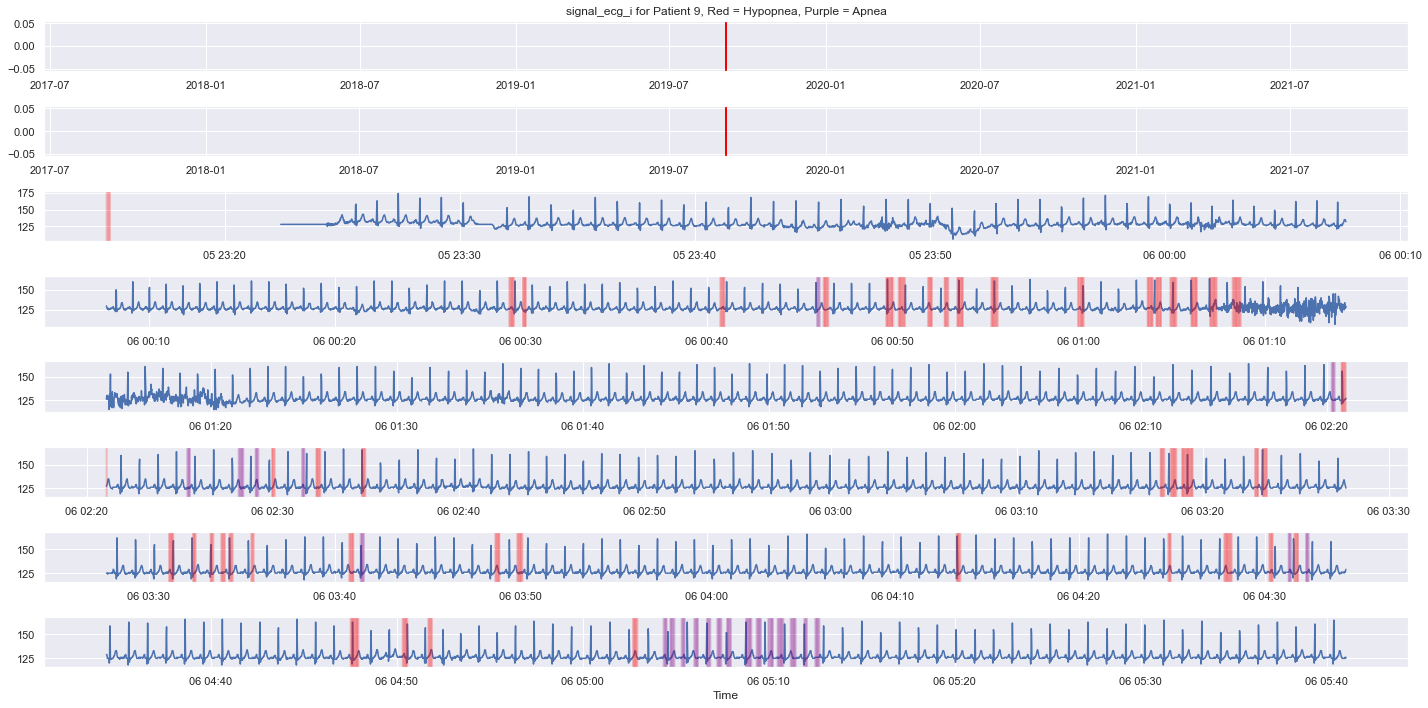

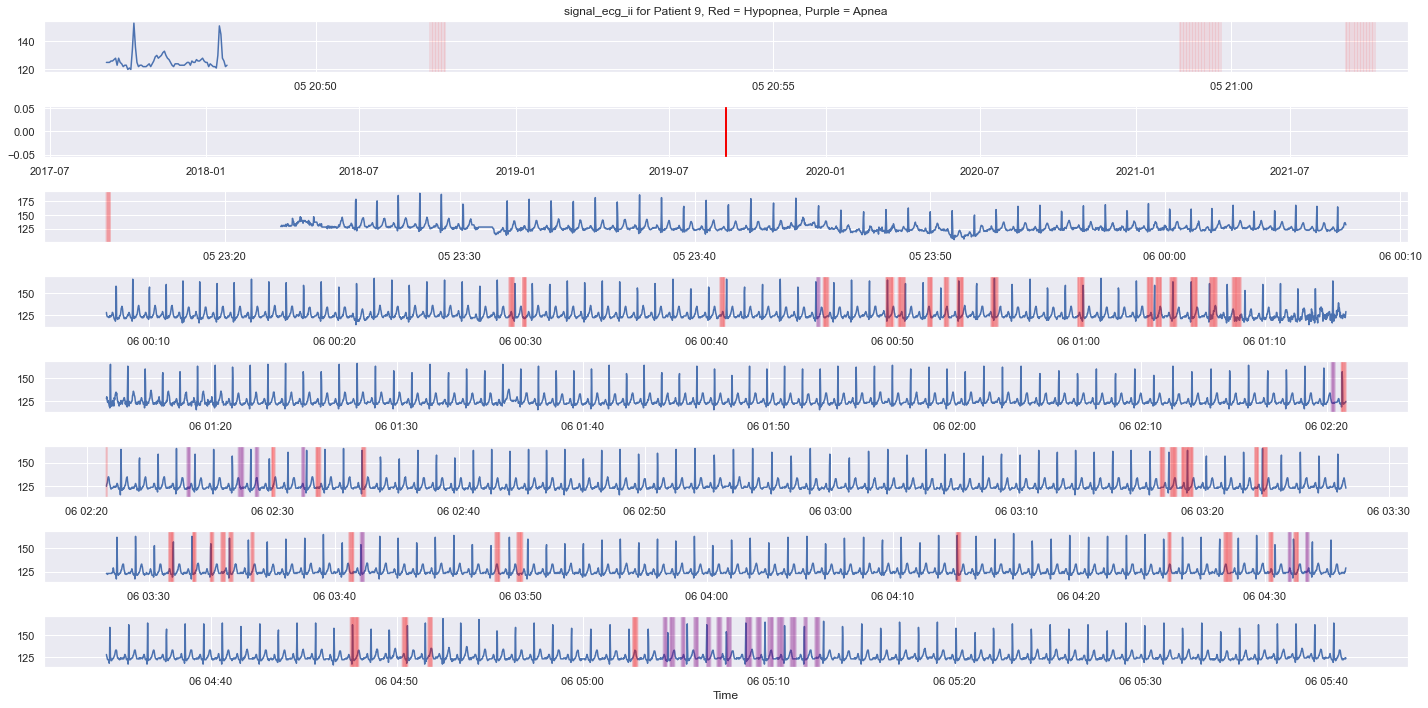

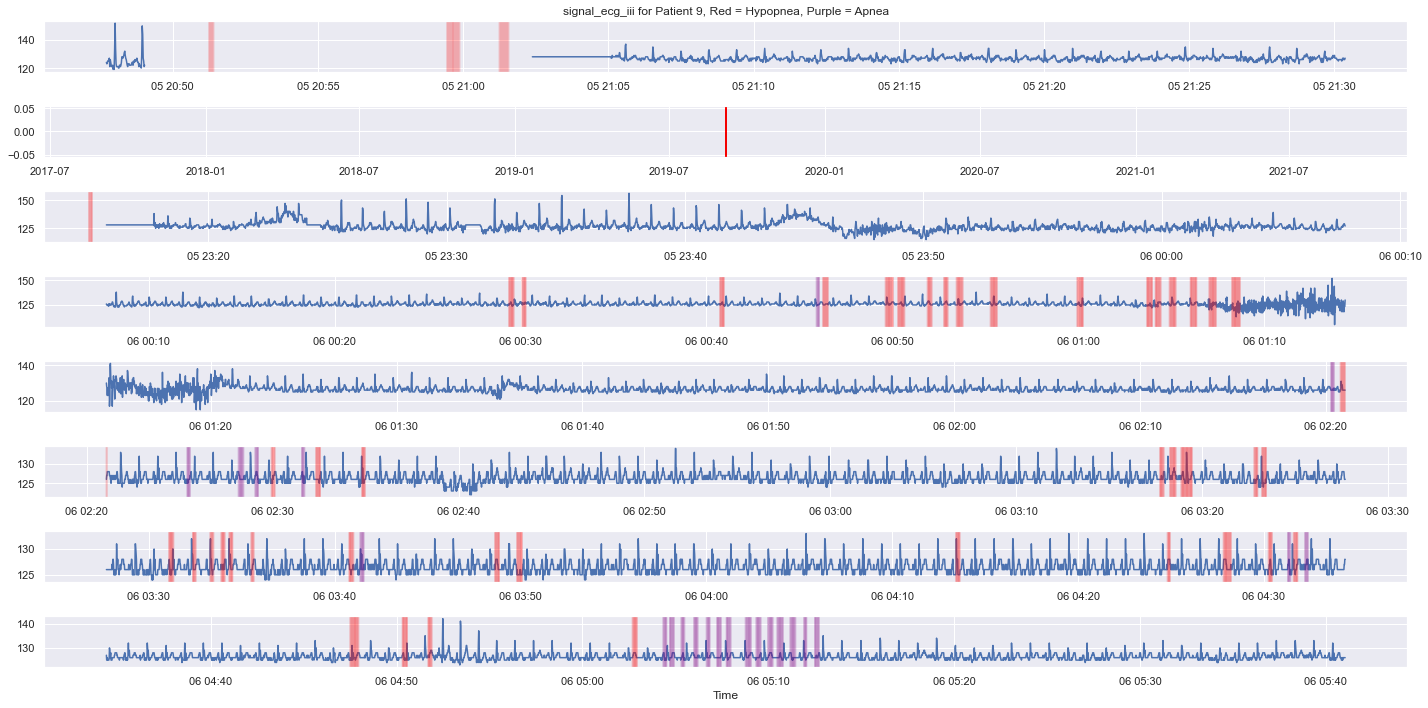

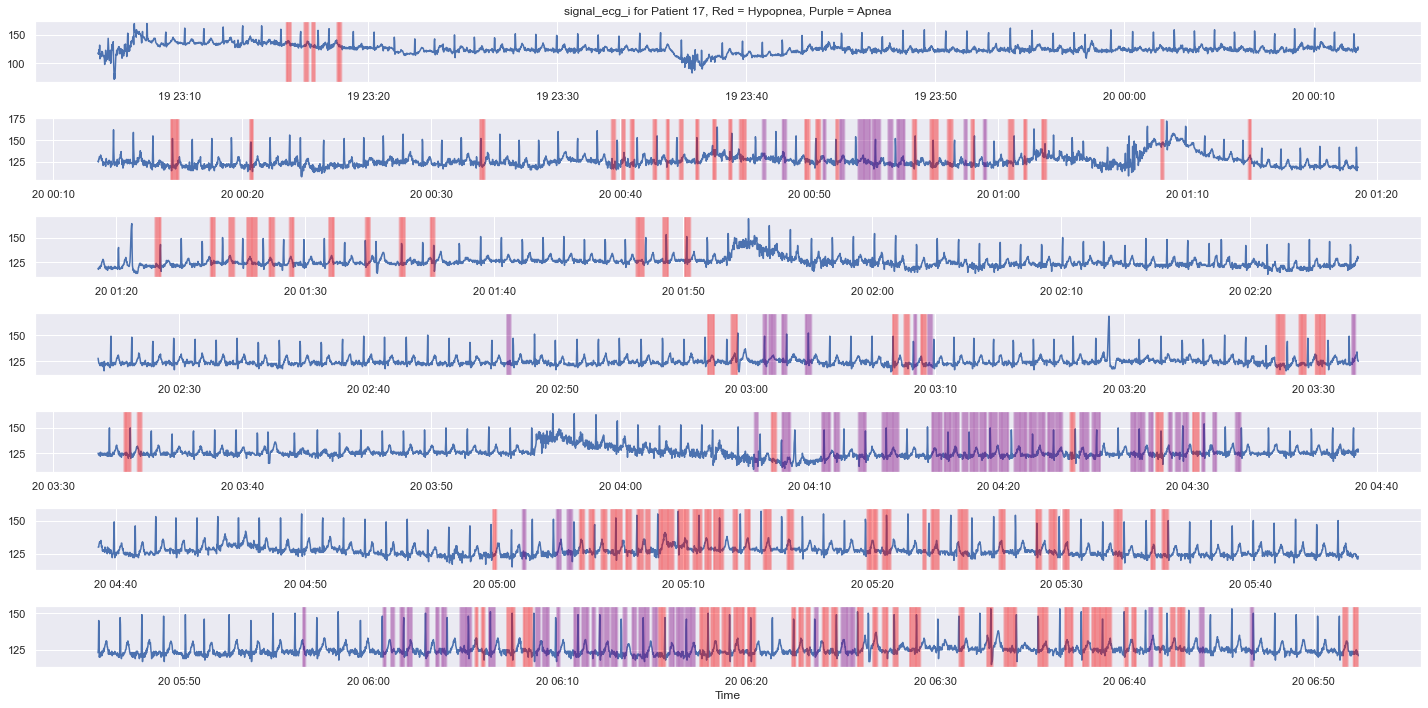

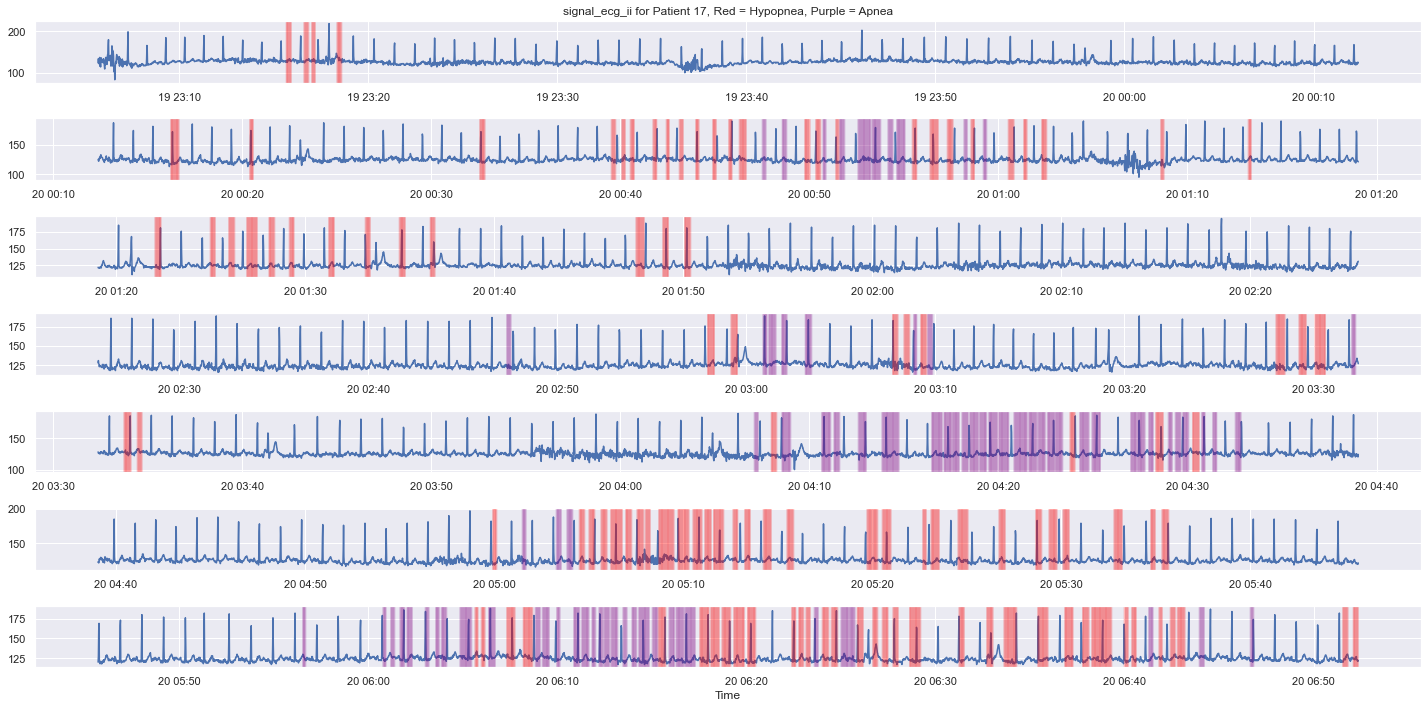

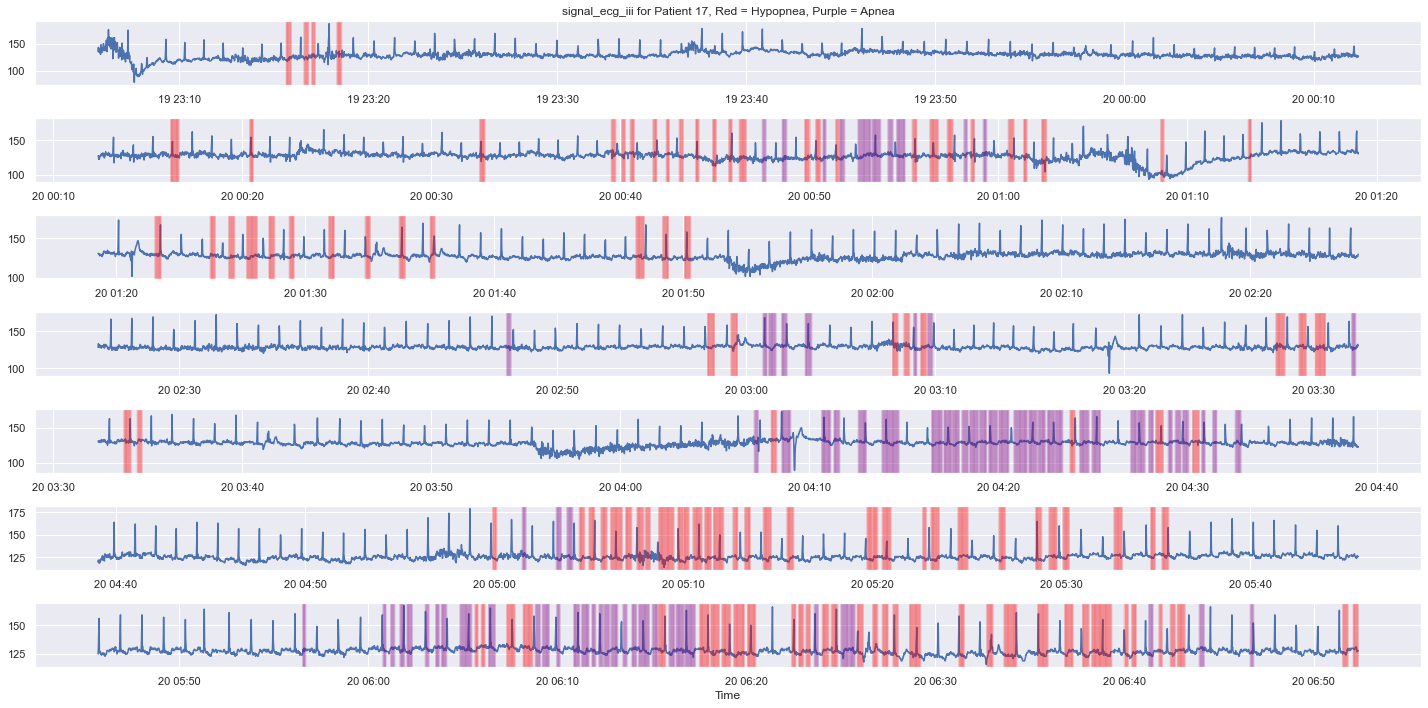

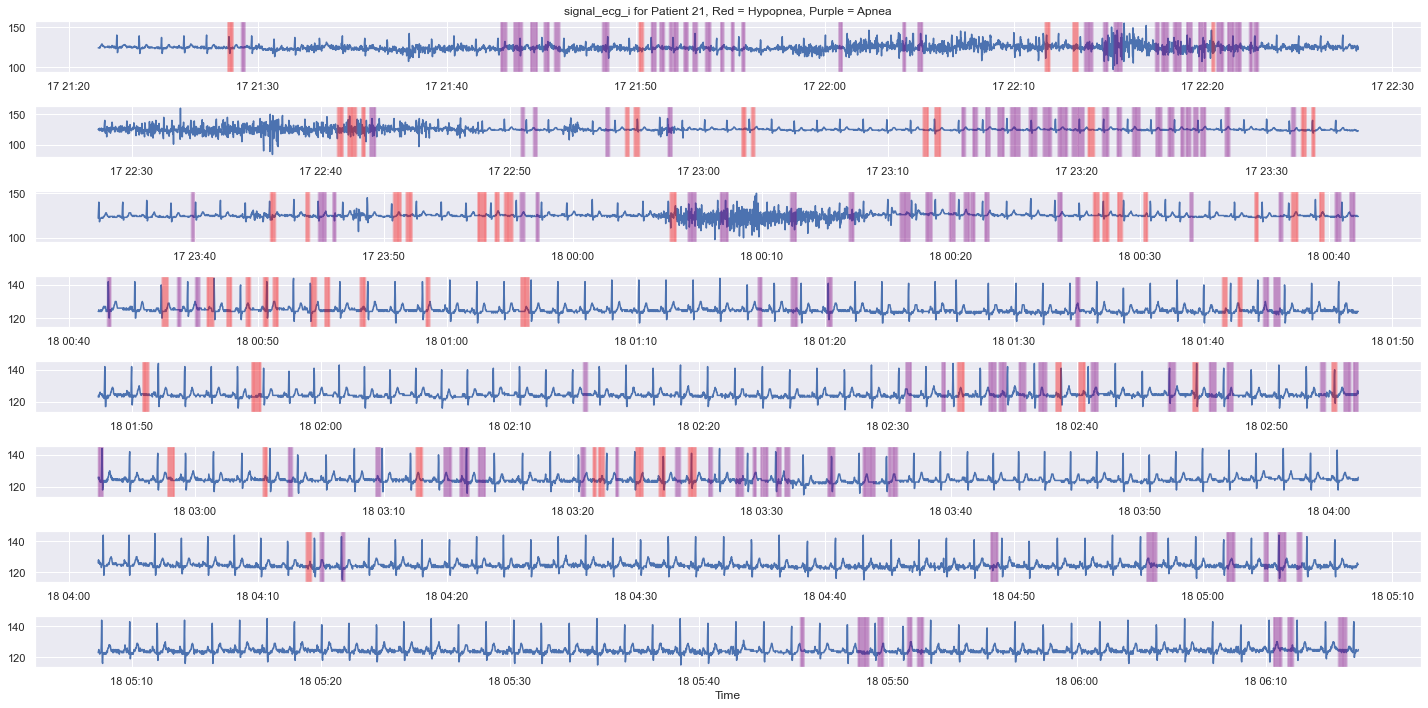

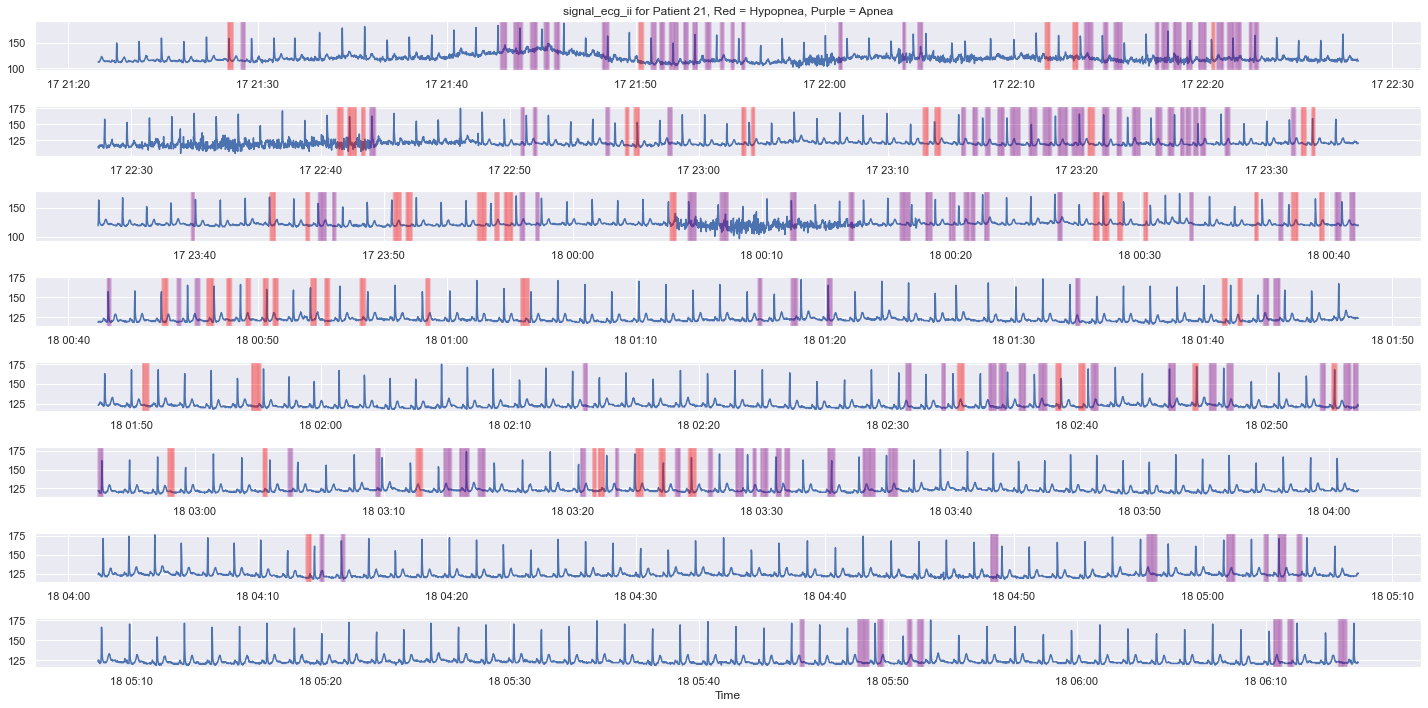

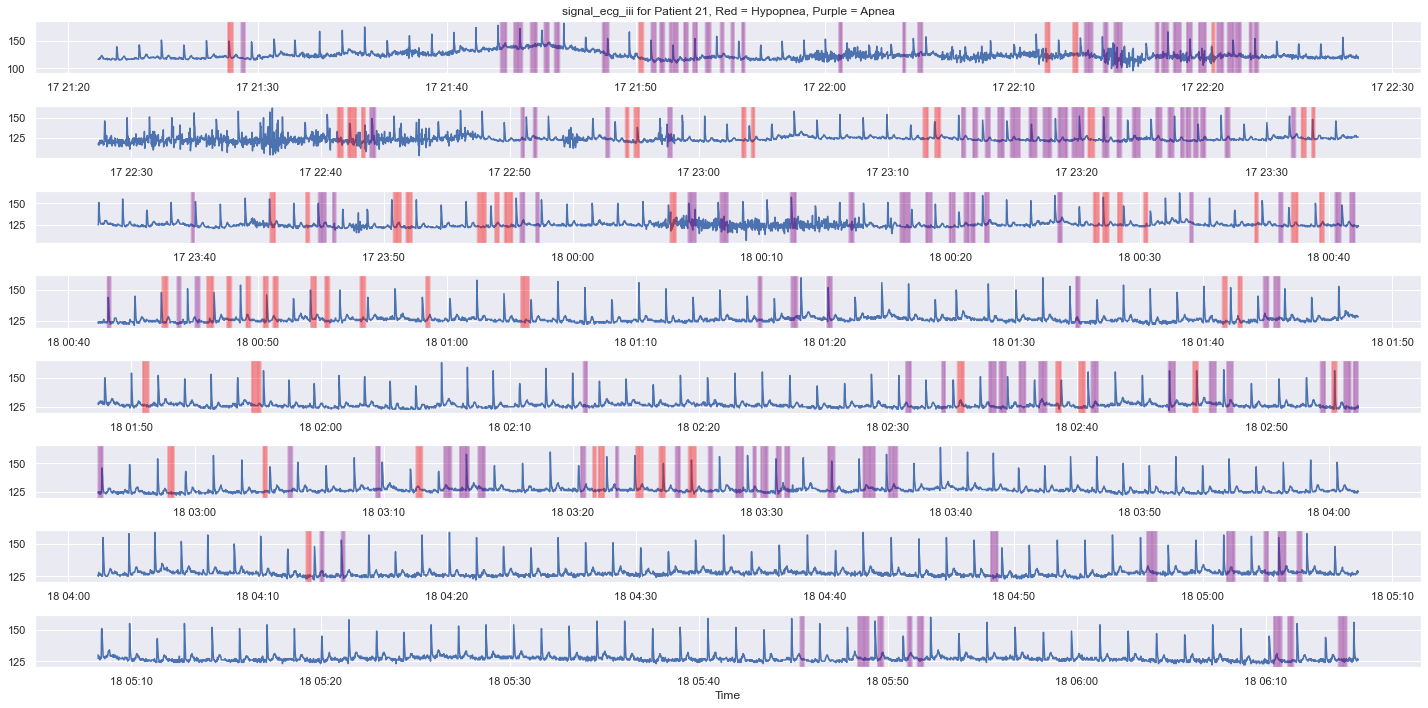

In [17]:
# Objective of the plot: to map the hypopnea and apnea events in patient readouts of ecg time series data for 
# multiple leads. We were hoping to visualize the any patterns that were present in the ecg data. From our plots,
# we cannot see a clear pattern between ecg time series data and hypopnea and apnea events. However, we are again 
# hopeful that the ecg time series data can be used to train a machine learning algorithm alongside the PSG data  
# to predict the hypopnea and apnea events.

for pt_num in pt_nums:
    patient = data[data['patient'] == pt_num]
    time = patient['timestamp_datetime']
    event = patient['event']
    
    # collecting the data in an easier form to plot
    for e in ecg_events:

        ecg = patient[e]

        huge_arr = []
        time_arr = []
        event_arr = []
        for i in event.index:
            event_arr = np.append(event_arr, event[i])
            huge_arr = np.append(huge_arr, ecg[i])
            time_arr = np.append(time_arr, time[i])

        # setting up plots -- 4000 was a number of points I chose that I thought 
        # didn't look too crowded in the space allocated for the plot
        num_plots = int(len(time_arr)/4000)
        fig, axs = plt.subplots(num_plots)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        fig.tight_layout()
        start = 0
        end = 4000
        for i in range(num_plots):
            # find the hypopnea and apnea events
            hypopnea = (event_arr[start:end] == 'HYPOPNEA')
            apnea = (event_arr[start:end] == 'APNEA-OBSTRUCTIVE')
            # plot the time series
            axs[i].plot(time_arr[start:end], huge_arr[start:end])
            # plot the hypopnea and apnea events
            for j in range(len(hypopnea)):
                if hypopnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='red', alpha=0.1)
            for j in range(len(apnea)):
                if apnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='purple', alpha=0.1)
            start += 4000
            end += 4000

        axs[0].set_title(str(e) + " for Patient "+ str(pt_num)+", Red = Hypopnea, Purple = Apnea")
        axs[num_plots-1].set_xlabel("Time")

The violin chart is similar to the box plot, but it can visually represent the distribution of the data

<AxesSubplot:>

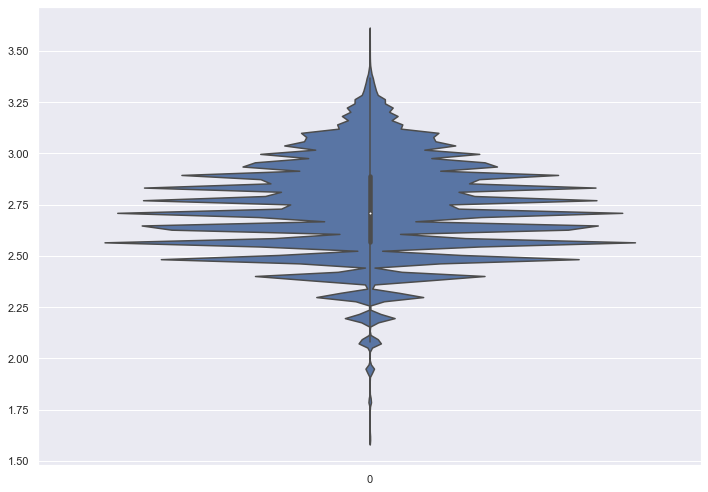

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.violinplot(np.log(data['RR(rpm)']))

Next we try to understand the histogram and kernel density function for each column of data so that we can find their distribution patterns and confidence intervals

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='HR(bpm)', ylabel='Density'>

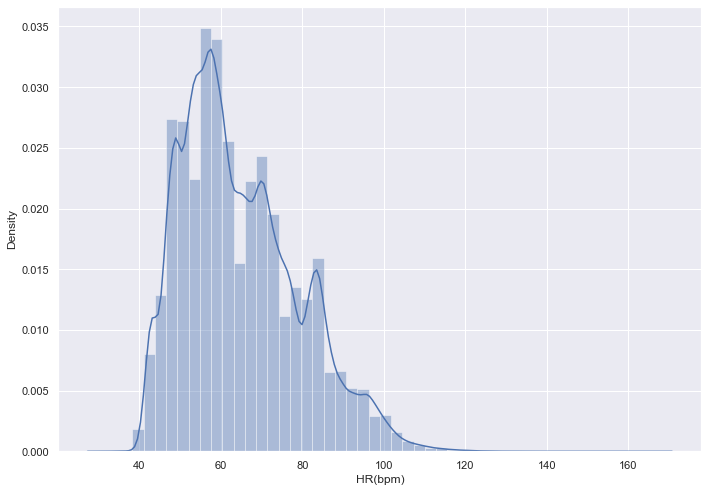

In [21]:
sns.distplot(data['HR(bpm)'])

Because there are so many different attributes, we need to explore the correlation between them. We give the relationship matrix between the different groups, the correlation coefficient and Spearman's rank correlation coefficient. It has a value between +1 and -1, where 1 is the total positive linear correlation, 0 is the nonlinear correlation, and -1 is the total negative linear correlation.

The purpose of correlation analysis is to understand the correlation between different variables, and the current data suggest that the correlation between them is not significant. However, not every kind of properties is very meaningful for detecting apnea, or they have different weights. We will continue to explore them in a follow-up study

In [24]:
num_cols=data.columns
data.corr() 

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min),anomaly
HR(bpm),1.000000,-0.104769,-0.269432,0.326877,0.223859,-0.001612
SpO2(%),-0.104769,1.000000,-0.230038,-0.129233,-0.095152,-0.071342
PI(%),-0.269432,-0.230038,1.000000,-0.116478,-0.065236,-0.055264
RR(rpm),0.326877,-0.129233,-0.116478,1.000000,0.176559,0.007326
PVCs(/min),0.223859,-0.095152,-0.065236,0.176559,1.000000,0.076380
anomaly,-0.001612,-0.071342,-0.055264,0.007326,0.076380,1.000000


In [25]:
data.corr('spearman')

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min),anomaly
HR(bpm),1.000000,-0.155781,-0.284131,0.333875,0.362928,-0.013222
SpO2(%),-0.155781,1.000000,-0.310639,-0.166651,-0.140439,-0.063236
PI(%),-0.284131,-0.310639,1.000000,-0.134339,-0.081252,-0.047883
RR(rpm),0.333875,-0.166651,-0.134339,1.000000,0.219612,0.013710
PVCs(/min),0.362928,-0.140439,-0.081252,0.219612,1.000000,0.085305
anomaly,-0.013222,-0.063236,-0.047883,0.013710,0.085305,1.000000


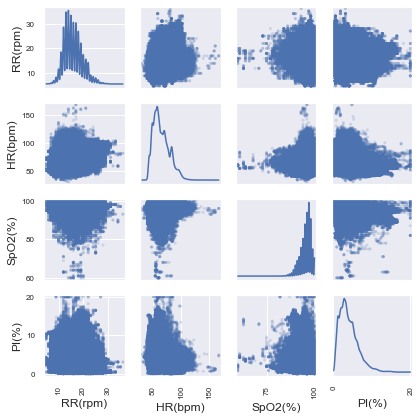

In [27]:
from pandas.plotting import scatter_matrix

df = pd.DataFrame(data, columns=['RR(rpm)', 'HR(bpm)', 'SpO2(%)', 'PI(%)'])

scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal="kde");